In [1]:
import numpy as np
from PIL import Image
import os

def load_images_and_masks(directory):
    images = []
    masks = []

    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        
        if filename.startswith('1'):  # Original images
            image = Image.open(filepath).convert('L')
            image = image.resize((128, 128))
            image = np.array(image) / 255.0
            images.append(image)
        
        elif filename.startswith('2'):  # Masks
            mask = Image.open(filepath).convert('L')
            mask = mask.resize((128, 128))
            mask = np.array(mask) / 255.0
            masks.append(mask)
    
    return np.array(images), np.array(masks)

selected_images_dir = 'selected_images_1500'
images, masks = load_images_and_masks(selected_images_dir)

# Check consistency
def check_consistency(images, masks):
    if len(images) != len(masks):
        print("Number of images and masks are not consistent.")
        return False
    else:
        print("Number of images and masks are consistent.")
        return True

if not check_consistency(images, masks):
    exit()

# Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=42)




Number of images and masks are consistent.


In [4]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate

# Define input shape
input_shape = (128, 128, 1)

def basic_unet(input_shape):
    inputs = Input(input_shape)

    # Downscaling path
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)

    # Upscaling path
    up1 = UpSampling2D(size=(2, 2))(conv3)
    up1 = concatenate([up1, conv2], axis=3)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(up1)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(conv4)

    up2 = UpSampling2D(size=(2, 2))(conv4)
    up2 = concatenate([up2, conv1], axis=3)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(up2)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(conv5)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv5)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Create and compile U-Net model
unet_model = basic_unet(input_shape)
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the U-Net model
history = unet_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=8)

# Evaluate the U-Net model
loss, accuracy = unet_model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

# Print layer names for feature extraction
for layer in unet_model.layers:
    print(layer.name)


Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.2765 - loss: 0.7105 - val_accuracy: 0.3420 - val_loss: 0.6019
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step - accuracy: 0.2983 - loss: 0.6300 - val_accuracy: 0.3420 - val_loss: 0.5967
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.2908 - loss: 0.6242 - val_accuracy: 0.3420 - val_loss: 0.6170
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.2965 - loss: 0.6235 - val_accuracy: 0.3420 - val_loss: 0.5945
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - accuracy: 0.3177 - loss: 0.6145 - val_accuracy: 0.3420 - val_loss: 0.5980
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.3400 - loss: 0.6000 - val_accuracy: 0.3420 - val_loss: 0.6077
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.3145 - loss: 0.6211 - val_accuracy: 0.3420 - val_loss: 0.5937
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.2980 - loss: 0.6238 - val_accuracy: 0.3420 - val_loss:

In [32]:
from tensorflow.keras.models import Model

# Extract features from a specific layer
feature_layer = unet_model.get_layer('conv2d_5').output
feature_extractor = Model(inputs=unet_model.input, outputs=feature_layer)

# Get features from training and testing data
train_features = feature_extractor.predict(X_train)
test_features = feature_extractor.predict(X_test)

print(f"Train features shape: {train_features.shape}")
print(f"Test features shape: {test_features.shape}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 626ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step
Train features shape: (239, 32, 32, 256)
Test features shape: (60, 32, 32, 256)


In [33]:
# Flatten the features
train_features_flattened = train_features.reshape(train_features.shape[0], -1)
test_features_flattened = test_features.reshape(test_features.shape[0], -1)

print(f"Flattened train features shape: {train_features_flattened.shape}")
print(f"Flattened test features shape: {test_features_flattened.shape}")


Flattened train features shape: (239, 262144)
Flattened test features shape: (60, 262144)


In [34]:
from tensorflow.keras.utils import to_categorical

# Convert masks to categorical format (binary classification)
num_classes = 2  # For binary classification
y_train_one_hot = to_categorical(y_train.flatten(), num_classes=num_classes)
y_test_one_hot = to_categorical(y_test.flatten(), num_classes=num_classes)

print(f"Shape of y_train_one_hot: {y_train_one_hot.shape}")
print(f"Shape of y_test_one_hot: {y_test_one_hot.shape}")


Shape of y_train_one_hot: (3915776, 2)
Shape of y_test_one_hot: (983040, 2)


In [35]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout

def create_vit_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Dense(512, activation='relu')(inputs)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Define input shape for ViT
input_shape_vit = (train_features_flattened.shape[1],)  # Flattened feature shape
num_classes = y_train_one_hot.shape[1]  # Number of classes

# Create and compile Vision Transformer model
vit_model = create_vit_model(input_shape_vit, num_classes)
vit_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [38]:
# Convert masks to categorical labels
from tensorflow.keras.utils import to_categorical

def prepare_labels(masks):
    masks_flattened = masks.reshape(masks.shape[0], -1)  # Flatten the masks for each image
    labels = np.array([np.argmax(np.bincount(mask.astype(int).flatten())) for mask in masks_flattened])  # Majority class as label
    return to_categorical(labels, num_classes=num_classes)

y_train_labels = prepare_labels(y_train)
y_test_labels = prepare_labels(y_test)

# Verify shapes
print(f"Shape of y_train_labels: {y_train_labels.shape}")
print(f"Shape of y_test_labels: {y_test_labels.shape}")


Shape of y_train_labels: (239, 2)
Shape of y_test_labels: (60, 2)


In [39]:
# Train the Vision Transformer model
history = vit_model.fit(
    train_features_flattened, 
    y_train_labels, 
    validation_data=(test_features_flattened, y_test_labels), 
    epochs=10, 
    batch_size=8
)


Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.7016 - loss: 0.7183 - val_accuracy: 0.7333 - val_loss: 0.6813
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.7200 - loss: 0.6764 - val_accuracy: 0.7333 - val_loss: 0.6786
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.7439 - loss: 0.6659 - val_accuracy: 0.7333 - val_loss: 0.6326
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.7607 - loss: 0.5338 - val_accuracy: 0.7333 - val_loss: 0.6021
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.7110 - loss: 0.6191 - val_accuracy: 0.7333 - val_loss: 0.6331
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.7575 - loss: 0.6009 - val_accuracy: 0.7333 - val_loss: 0.6380
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.6134 - loss: 0.6688 - val_accuracy: 0.7333 - val_loss: 0.6298
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.7019 - loss: 0.6123 - val_accuracy: 0.7333 - val_loss:

In [41]:
# Evaluate the Vision Transformer model
loss, accuracy = vit_model.evaluate(test_features_flattened, y_test_labels)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.7389 - loss: 0.5971
Test Loss: 0.5970
Test Accuracy: 0.7333


In [42]:
# Save the ViT model
vit_model.save('vit_model_v1_unet.h5')


In [44]:
from tensorflow.keras.models import load_model

# Load the saved ViT model
loaded_vit_model = load_model('vit_model_v1_unet.h5')

# Evaluate the loaded model to ensure it's working correctly
loss, accuracy = loaded_vit_model.evaluate(test_features_flattened, y_test_labels)
print(f'Loaded Model Test Loss: {loss:.4f}')
print(f'Loaded Model Test Accuracy: {accuracy:.4f}')


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7389 - loss: 0.5971
Loaded Model Test Loss: 0.5970
Loaded Model Test Accuracy: 0.7333


In [45]:
from tensorflow.keras.models import load_model

# Load the saved ViT model
loaded_vit_model = load_model('vit_model_v1_unet.h5')

# Evaluate the loaded model to ensure it's working correctly
loss, accuracy = loaded_vit_model.evaluate(test_features_flattened, y_test_labels)
print(f'Loaded Model Test Loss: {loss:.4f}')
print(f'Loaded Model Test Accuracy: {accuracy:.4f}')


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7389 - loss: 0.5971
Loaded Model Test Loss: 0.5970
Loaded Model Test Accuracy: 0.7333


In [46]:
import tensorflow as tf

# Load the saved model
loaded_model = tf.keras.models.load_model('vit_model_v1_unet.h5')


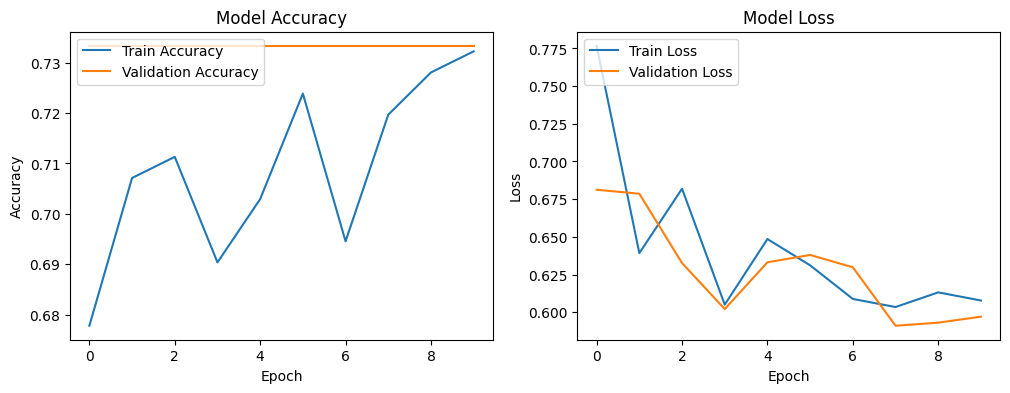

In [47]:
import matplotlib.pyplot as plt

# Assuming you have the history from training
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    
    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    
    plt.show()

# Plot the history
plot_training_history(history)
